## Trabajador experto en conocimiento (RAG)

### Un agente de respuesta a preguntas que es un trabajador experto en conocimiento
### Para ser utilizado por empleados de Insurellm, una empresa de tecnología de seguros
### El agente debe ser preciso y la solución debe ser de bajo costo.

Este proyecto utilizará RAG (Retrieval Augmented Generation) para garantizar que nuestro asistente de preguntas y respuestas tenga una alta precisión.

In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
# imports para langchain y Chroma y plotly

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [3]:
# El precio es un factor para nuestra empresa, por eso vamos a utilizar un modelo de bajo costo.

MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [4]:
# Cargar variables de entorno en un archivo llamado .env

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [5]:
# Leer documentos usando los cargadores de LangChain
# Tomar todo lo que está en todas las subcarpetas de nuestra base de conocimiento

folders = glob.glob("knowledge-base/*")

# Con agradecimientos a CG y Jon R, estudiantes del curso, por esta solución necesaria para algunos usuarios.
text_loader_kwargs = {'encoding': 'utf-8'}
# Si esto no funciona, algunos usuarios de Windows podrían necesitar descomentar la siguiente línea.
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

# Ten en cuenta:

En la siguiente celda, dividimos el texto en fragmentos.

Dos estudiantes me informaron que la siguiente celda hizo que su computadora se bloqueara.
Pudieron solucionarlo cambiando chunk_size de 1000 a 2000 y chunk_overlap de 200 a 400.
Esto no debería ser obligatorio, pero si le sucede a usted, ¡realice ese cambio!
(Tenga en cuenta que LangChain puede emitir una advertencia sobre un fragmento mayor a 1000; esto se puede ignorar sin problemas).

_Muchas gracias a Steven W y Nir P por esta valiosa contribución._

In [6]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 1252, which is longer than the specified 1000


In [7]:
len(chunks)

137

In [8]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: contracts, products, employees, company


## Una nota al margen sobre las incrustaciones y los "LLM de codificación automática"

Asignaremos cada fragmento de texto a un vector que representa el significado del texto, conocido como incrustación.

OpenAI ofrece un modelo para hacer esto, que utilizaremos llamando a su API con un código LangChain.

Este modelo es un ejemplo de un "LLM de codificación automática" que genera una salida dada una entrada completa.
Es diferente a todos los demás LLM que hemos analizado hoy, que se conocen como "LLM autorregresivos", y generan tokens futuros basados ​​solo en el contexto pasado.

Otro ejemplo de un LLM de codificación automática es BERT de Google. Además de la incrustación, los LLM de codificación automática se utilizan a menudo para la clasificación.

### Nota al margen

En la semana 8 volveremos a RAG y a las incrustaciones vectoriales, y utilizaremos un codificador vectorial de código abierto para que los datos nunca abandonen nuestra computadora; esa es una consideración importante cuando se crean sistemas empresariales y los datos deben permanecer internos.

In [9]:
# Coloque los fragmentos de datos en un almacén vectorial que asocie una incrustación vectorial con cada fragmento

embeddings = OpenAIEmbeddings()

In [10]:
# Verifique si ya existe un almacén de datos Chroma; si es así, elimine la colección para comenzar desde cero

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

In [11]:
# ¡Crea nuestro almacén de vectores Chroma!

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore creado con {vectorstore._collection.count()} documentos")

Vectorstore created with 137 documents


In [12]:
# Obtenemos un vector y encuentramos cuántas dimensiones tiene

collection = vectorstore._collection
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"Los vectores tienen {dimensions:,} dimensiones")

Los vectores tienen 1,536 dimensiones


In [15]:
print(sample_embedding)

[-0.01937656 -0.01097325 -0.00347928 ... -0.00429004 -0.03100249
 -0.01543326]


## Visualización del almacén de vectores

Tomémonos un minuto para observar los documentos y sus vectores de incrustación para ver qué está sucediendo.

In [16]:
# Prework

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
doc_types = [metadata['doc_type'] for metadata in result['metadatas']]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]


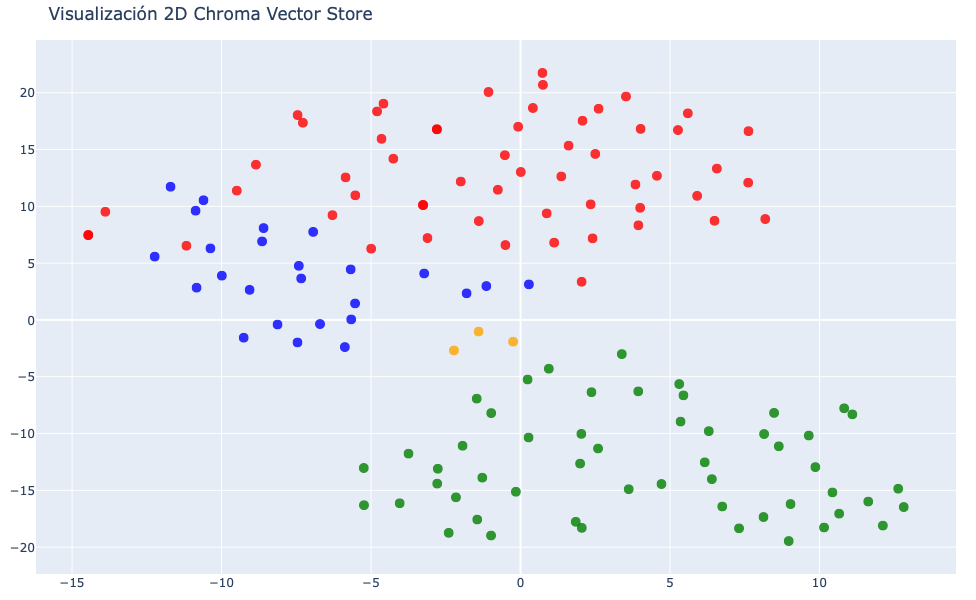

In [18]:
# ¡A los humanos nos resulta más fácil visualizar cosas en 2D!
# Reducir la dimensionalidad de los vectores a 2D usando t-SNE
# (incrustación de vecinos estocásticos distribuidos en t)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=10, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='Visualización 2D Chroma Vector Store',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

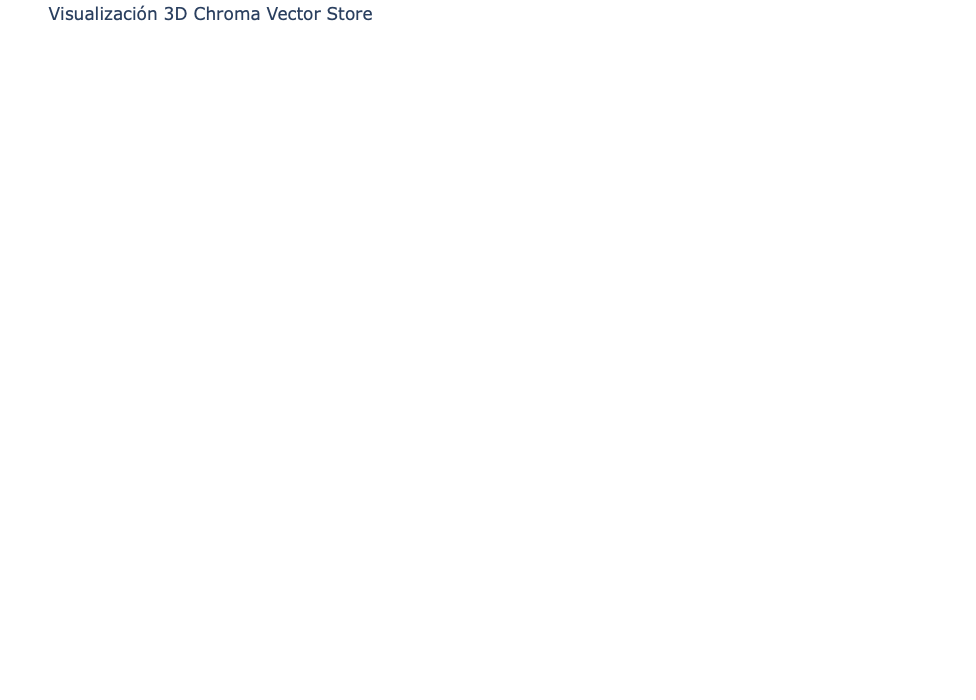

In [19]:
# Vamos a probar con 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='Visualización 3D Chroma Vector Store',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()